In [18]:
import nltk
import re

import pyLDAvis as plda
plda.enable_notebook()
import pyLDAvis.gensim

import gensim
import pandas as pd
import numpy as np
import sqlalchemy as sa
%matplotlib inline
%config InlineBackend.figure_format='retina'
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
sns.set_context('talk')
sns.set_style('darkgrid') 
plt.rcParams['figure.figsize'] = 12, 8  # plotsize
pd.set_option('display.max_columns', 500)
# weave, alfred, localfred = pymysql engines

In [23]:
pd.read_sql_query("""
SHOW TABLES
""", alfred)

,Tables_in_alfred_prod
0,email_logs
1,email_types
2,filter_views
3,filter_views_users
4,match_candidates
5,matches
6,plans
7,registration_metas
8,registrations
9,schema_migrations


In [46]:
alfredlookingfor = pd.read_sql_query("""
SELECT users.first_name, users.last_name, users.email, user_prefs.looking_for, user_prefs.hood, user_prefs.hood_notes
FROM users
JOIN user_prefs ON users.id = user_prefs.user_id
""", alfred)

In [27]:
activealfred = pd.read_sql_query("""
SELECT id as alfred_id, first_name as alfred_first, last_name as alfred_last, email as alfred_email
FROM users
WHERE active = 1
""", alfred)

In [29]:
activealfred.loc[:,'alfred_email'] = activealfred.alfred_email.str.lower()

In [119]:
activealfred.head()

,alfred_id,alfred_first,alfred_last,alfred_email
0,1,Chris,Mo,n3xeurope@gmail.com
1,2,Andrew,Norris,andrew@taplytics.com
2,3,Maria,Greger,mcgseattle@yahoo.com
3,4,Andrea Joseph,Joseph,andreajoseph@kw.com
4,5,David,Yalland,yalland@live.co.uk


In [33]:
email_python_list = activealfred.alfred_email.tolist()
email_python_string = str(email_python_list)
email_sql_list = email_python_string.replace('[', '(').replace(']', ')')

In [34]:
weavesum = pd.read_sql_query("""
SELECT users.email, users.first_name, users.last_name, users.summary
FROM users
WHERE users.email in {email_list}
""".format(email_list=email_sql_list), weave)

In [39]:
notnullweavesum = pd.read_sql_query("""
SELECT users.email, users.first_name, users.last_name, users.headline, users.summary
FROM users
WHERE users.email in {email_list}
AND users.summary IS NOT NULL
""".format(email_list=email_sql_list), weave)

In [47]:
alfredlookingfor.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1452 entries, 0 to 1451
Data columns (total 6 columns):
first_name     1452 non-null object
last_name      1452 non-null object
email          1452 non-null object
looking_for    1452 non-null object
hood           1452 non-null object
hood_notes     112 non-null object
dtypes: object(6)
memory usage: 79.4+ KB


In [40]:
notnullweavesum.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 422 entries, 0 to 421
Data columns (total 5 columns):
email         422 non-null object
first_name    422 non-null object
last_name     422 non-null object
headline      422 non-null object
summary       422 non-null object
dtypes: object(5)
memory usage: 19.8+ KB


In [2]:
# weavesum = pd.read_pickle('../data/weavesummaries.pkl') 

In [54]:
wnl = nltk.stem.WordNetLemmatizer()
stopnltk = nltk.corpus.stopwords.words('english')

def lowertitle(word):
        if word.istitle():
            word = word.lower()
        return word
    
def doc_lower_title(doc):
    return " ".join([lowertitle(word) for word in doc.split()])

def corpus_lower_title(corpus):
    return [doc_lower_title(doc) for doc in corpus]

def lemmatize_doc(doc):
    return " ".join([wnl.lemmatize(i) for i in nltk.word_tokenize(doc)])

def lemmatize_corpus(prepared_corpus):
    lem_corpus = []
    for doc in prepared_corpus:
        lem_corpus.append(lemmatize_doc(doc))
    return lem_corpus

def alphanum_prep_corpus(corpus, num=True):
    if num:
        regex = re.compile('[^a-zA-Z0-9]')
    else:
        regex = re.compile('[^a-zA-Z]')
    corpus = [' '.join(j.decode('cp1250').encode('ascii', 'ignore').split()) for j in corpus]
    corpus = [re.sub(r'https?:\/\/.*\.com', '', j) for j in corpus]
    corpus = [re.sub(r'https?:\/\/.*\.net', '', j) for j in corpus]
    corpus = [re.sub(r'https?:\/\/.*\.html', '', j) for j in corpus]
    corpus = [re.sub(r'[\']', '', j) for j in corpus]
    corpus = [re.sub(r'[\"]', ' ', j) for j in corpus]
    corpus = [regex.sub(' ', j) for j in corpus]
    return corpus_lower_title(corpus)

In [41]:
notnullweavesum.head(1)

,email,first_name,last_name,headline,summary
0,jhychao@gmail.com,Jessica,Chao,designing an innovative health system; not a p...,Always learning whether in healthcare or tech....


In [48]:
lookingcorp = alfredlookingfor.loc[:,['looking_for',]].apply(lambda row: ' '.join(row.dropna()), axis=1).tolist()
summarycorp = notnullweavesum.loc[:,['headline','summary',]].apply(lambda row: ' '.join(row.dropna()), axis=1).tolist()

In [50]:
lookingcorp[0]

'marketing managers'

In [51]:
summarycorp[0]

'designing an innovative health system; not a paradox Always learning whether in healthcare or tech. Love designing the next product. \n\nTwitter: jessicahchao'

In [61]:
def process_corpus_to_dictionary_ingestion(corp, numeric=False):
    alphacorp = alphanum_prep_corpus(corp, num=numeric)
    alphalemmcorp = lemmatize_corpus(alphacorp)
    alphastopcorp = [[word for word in t.split() if (word not in stopnltk)] for t in alphalemmcorp]
    #alphadic = gensim.corpora.Dictionary(alphastopcorp)
    #alphacorp = [alphadic.doc2bow(txt) for txt in alphastopcorp]
    return alphastopcorp

In [62]:
lookcorp = process_corpus_to_dictionary_ingestion(lookingcorp)

In [64]:
sumcorp = process_corpus_to_dictionary_ingestion(summarycorp)

In [57]:
weavedic = gensim.corpora.Dictionary.load('../data/20150616_weave_summaries.dict')

In [58]:
weavelda = gensim.models.LdaModel.load('../data/20150616_weave_summaries.lda')

In [82]:
n = 7
print lookingcorp[n]
print lookcorp[n]

Designers, Developers, Anyone into startups, People in the manufacturing industry 
[u'designer', u'developer', u'anyone', u'startup', u'people', u'manufacturing', u'industry']


In [83]:
weavelda[weavedic.doc2bow(lookcorp[7])]

[(3, 0.23299856449570969),
 (18, 0.29296312808368519),
 (19, 0.36778830685637093)]

In [ ]:
# from checking a couple of them, it looks like this is actually working
# a caveat to this working is that I see the same phenomenon that Alex M
# saw where a given BOW-representation of a document is usually assigned
# only one strong vector
# n=7 is an exception, where many of the vectors are 0, and three have high representation

In [89]:
# now I want to try gensim's built in similarity function
# I'll prepare the sumcorp as the indexed corpus and query individual lookcorp entries
# first I need to get the vector space representation of each corpus
Vlookcorp = [weavedic.doc2bow(txt) for txt in lookcorp]

In [93]:
Vlookcorp[2]

[(27, 1),
 (86, 1),
 (138, 3),
 (147, 1),
 (148, 1),
 (293, 3),
 (358, 1),
 (1091, 1),
 (1266, 1),
 (3899, 1)]

In [94]:
Vsumcorp = [weavedic.doc2bow(txt) for txt in sumcorp]

In [99]:
index = gensim.similarities.Similarity(weavelda[Vsumcorp])#, num_features=20)

In [104]:
sims = [index[weavelda[doc]] for doc in Vlookcorp]

In [105]:
sims[0]

array([ 0.04504429,  0.04775451,  0.04277437,  0.03738598,  0.03360158,
        0.0261571 ,  0.04881716,  0.04553216,  0.25455901,  0.61914611,
        0.04737482,  0.03886943,  0.76093   ,  0.27950233,  0.2371421 ,
        0.64747137,  0.04087946,  0.04226099,  0.04008893,  0.03871169,
        0.04080083,  0.03947026,  0.17198591,  0.43770826,  0.04089198,
        0.03037235,  0.04566391,  0.03938622,  0.03428117,  0.04634874,
        0.04044148,  0.28516501,  0.30265236,  0.08860339,  0.14379816,
        0.11060108,  0.75342697,  0.11173419,  0.38067678,  0.04818581,
        0.0431278 ,  0.05720795,  0.97713119,  0.03841275,  0.03843111,
        0.03029627,  0.03824211,  0.69461036,  0.04692573,  0.56561565,
        0.20421702,  0.02622122,  0.10529269,  0.03755296,  0.64292294,
        0.25520557,  0.16296208,  0.02763331,  0.10467546,  0.02914471,
        0.03597167,  0.31258658,  0.04234633,  0.04095436,  0.04125113,
        0.02425356,  0.23062015,  0.04006895,  0.10062347,  0.05

In [106]:
simsorted = sorted(enumerate(sims[0]), key=lambda item: -item[1])

In [145]:
print simsorted[-10:]

[(118, 0.026821941), (51, 0.026221219), (5, 0.026157103), (258, 0.026143735), (143, 0.02595973), (71, 0.024253564), (65, 0.024253562), (136, 0.024253562), (229, 0.024253562), (309, 0.024253562)]


In [147]:
weavelda[lookcorp[0]]

ValueError: too many values to unpack

In [144]:
print sumcorp[335][0:10], sumcorp[190][0:10], sumcorp[155][0:10]

[u'marketing', u'advisor', u'chambre', u'de', u'commerce', u'du', u'montreal', u'mtropolitain', u'marketing', u'communication'] [u'senior', u'marketing', u'digital', u'creative', u'executive', u'experienced', u'cable', u'broadcast', u'digital', u'executive'] [u'online', u'marketing', u'ecommerce', u'strategy', u'im', u'online', u'marketer', u'strong', u'experience', u'email']


In [146]:
print sumcorp[136][0:10], sumcorp[229][0:10], sumcorp[309][0:10]

['music', 'artist', 'event', 'creator', 'songwriter', 'recording', 'artist'] [u'founder', u'CEO', u'parantez', u'com', u'altug', u'beser', u'entrepreneur', u'co', u'founder', u'several'] ['CPA', 'FAR', 'passed', 'BEC', 'passed']


In [ ]:
# it looks like it works pretty well
# now I need to decide how I want to do the matching
# I think I can just make a 2d array, (looking, summary)
# and roll that up into a dataframe then go from there

In [123]:
print len(sims)
print len(sims[0])
sims2d = np.array(sims)
sims2d.shape

1452
422


(1452, 422)

In [125]:
simdf = pd.DataFrame.from_records(sims2d) # rows are lookups, columns are summaries

In [127]:
simdf.shape

(1452, 422)

count    1452.000000
mean        0.955195
std         0.059294
min         0.558458
25%         0.952327
50%         0.979130
75%         0.985931
max         1.000000
dtype: float64


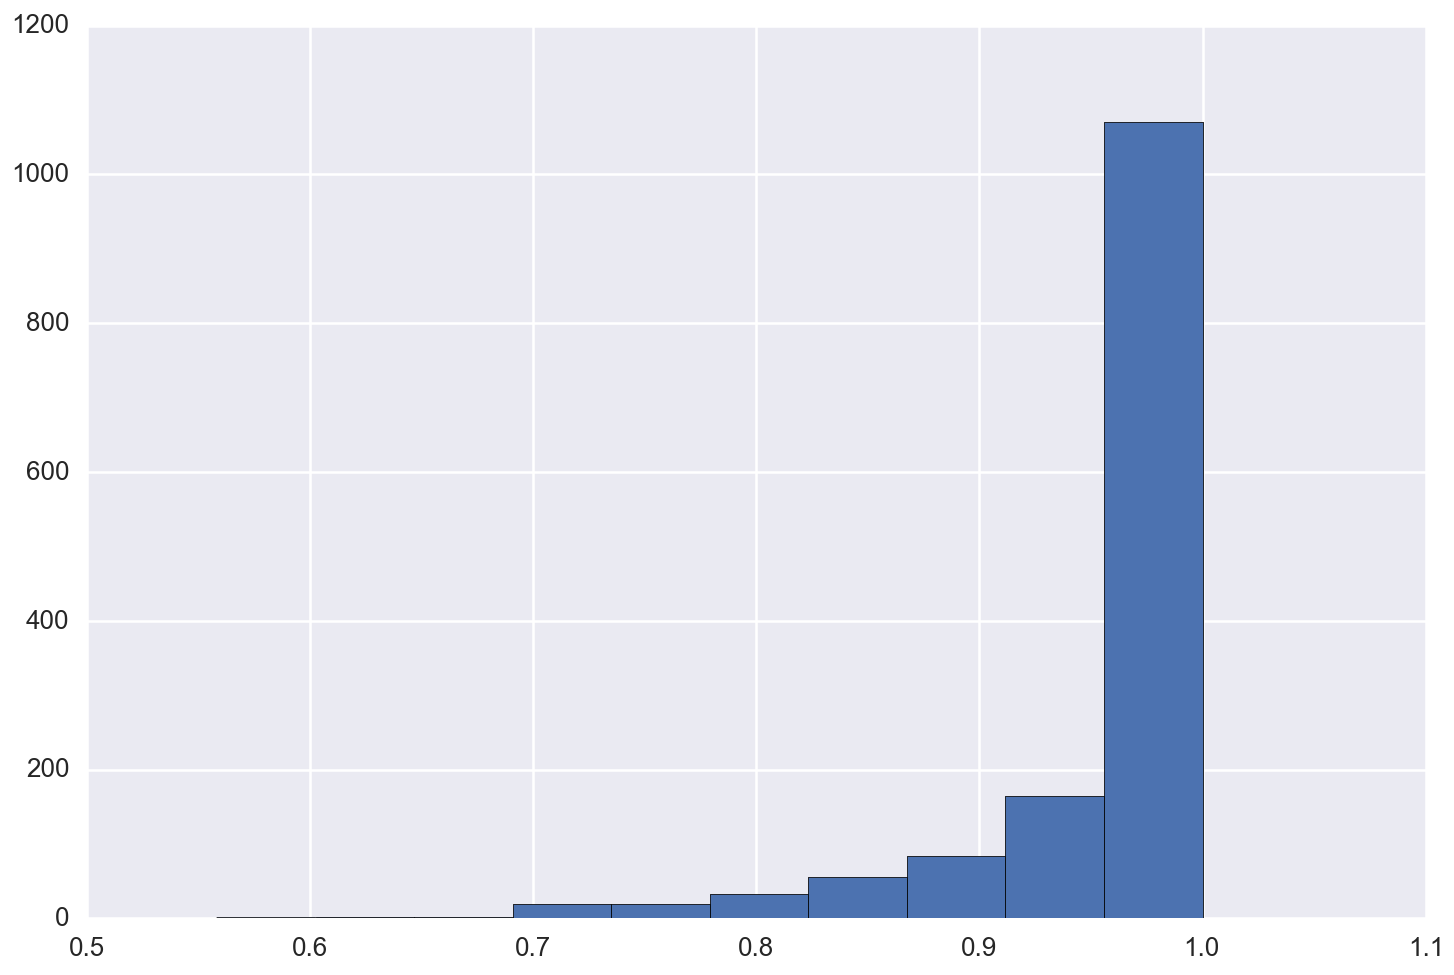

In [140]:
print simdf.max(axis=1).describe()
# so it seems like every looking for query has at least one good match
simdf.max(axis=1).hist()

count    422.000000
mean       0.923596
std        0.077018
min        0.325695
25%        0.891364
50%        0.944586
75%        0.976192
max        1.000000
dtype: float64


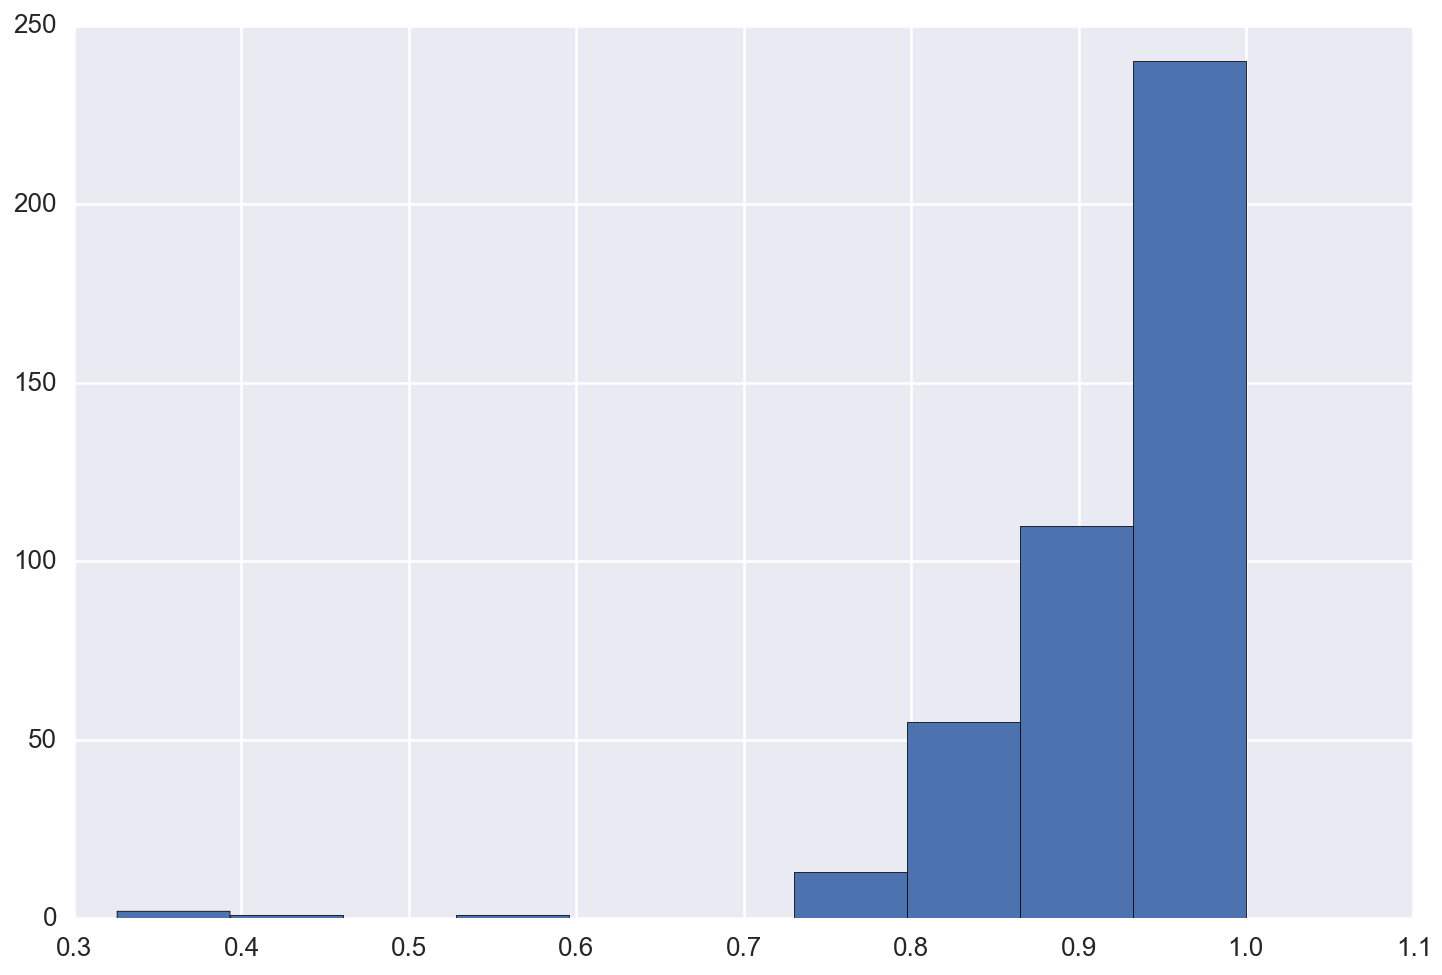

In [141]:
print simdf.max(axis=0).describe()
# from the perspective of summaries, there are a few that don't even have a single good match using 
# a completely arbitrary metric of (max similarity > 0.5)
simdf.max(axis=0).hist()